Sure! I'll provide an example of using an autoencoder for anomaly detection using the PyTorch framework. We'll go through the following steps:

1. **Understanding Autoencoders and Anomaly Detection**
2. **Setting Up the Environment**
3. **Preparing the Dataset**
4. **Defining the Autoencoder Model**
5. **Training the Autoencoder**
6. **Performing Anomaly Detection**
7. **Evaluating the Results**




## 1. Understanding Autoencoders and Anomaly Detection

**Autoencoders** are neural networks designed to learn efficient codings of input data in an unsupervised manner. They consist of two main parts:

- **Encoder**: Compresses the input into a latent-space representation.
- **Decoder**: Reconstructs the input from the latent space.

The goal is to minimize the reconstruction error between the input and the output.

In **anomaly detection**, autoencoders are trained on "normal" data and learn to reconstruct it well. When they see "anomalous" data (data that differs from the training distribution), they struggle to reconstruct it, resulting in a higher reconstruction error. By setting a threshold on this error, we can classify inputs as normal or anomalous.

---

## 2. Setting Up the Environment

First, ensure you have PyTorch installed:



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset


## 3. Preparing the Dataset

We'll use the MNIST dataset for this example. We'll consider the digit '0' as normal data and all other digits as anomalies.



In [12]:
# Transformation to apply to the images
transform = transforms.Compose([transforms.ToTensor()])

# Load the MNIST dataset
train_dataset = datasets.MNIST(
    root="data", train=True, transform=transform, download=True
)
test_dataset = datasets.MNIST(
    root="data", train=False, transform=transform, download=True
)

# Filter the dataset to only include the normal class (digit '0')
normal_class = 0

# Indices of normal data in training set
train_indices = [i for i, (x, y) in enumerate(train_dataset) if y != normal_class]
# Indices of normal and anomalous data in test set
test_indices_normal = [i for i, (x, y) in enumerate(test_dataset) if y != normal_class]
test_indices_anomalous = [
    i for i, (x, y) in enumerate(test_dataset) if y == normal_class
]

# Subset the datasets
train_dataset_normal = Subset(train_dataset, train_indices)
test_dataset_normal = Subset(test_dataset, test_indices_normal)
test_dataset_anomalous = Subset(test_dataset, test_indices_anomalous)

# Data loaders
batch_size = 64

train_loader = DataLoader(train_dataset_normal, batch_size=batch_size, shuffle=True)
test_loader_normal = DataLoader(
    test_dataset_normal, batch_size=batch_size, shuffle=False
)
test_loader_anomalous = DataLoader(
    test_dataset_anomalous, batch_size=batch_size, shuffle=False
)



**Explanation:**

- We define a transformation to convert images to tensors.
- We load the MNIST dataset.
- We filter the dataset to only include images of the digit '0' for normal data.
- For testing, we have both normal and anomalous data.
- We create data loaders for easy batch processing.

---


In [13]:
## 4. Defining the Autoencoder Model


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),
            nn.ReLU(True),
            nn.Linear(12, 3),  # Latent space
        )
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid(),  # To get output values between 0 and 1
            nn.Unflatten(1, (1, 28, 28)),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



**Explanation:**

- **Encoder**: Compresses the 28x28 image into a 3-dimensional latent space.
- **Decoder**: Reconstructs the image from the latent space.
- Uses `ReLU` activations in hidden layers and `Sigmoid` activation in the output layer to ensure pixel values are between 0 and 1.

---

## 5. Training the Autoencoder



In [14]:
# Initialize the model, loss function, and optimizer
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5

for epoch in range(num_epochs):
    total_loss = 0
    for data in train_loader:
        imgs, _ = data  # Ignore labels
        outputs = model(imgs)
        loss = criterion(outputs, imgs)  # Reconstruction loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")

Epoch [1/5], Loss: 0.0597
Epoch [2/5], Loss: 0.0424
Epoch [3/5], Loss: 0.0385
Epoch [4/5], Loss: 0.0369
Epoch [5/5], Loss: 0.0357




**Explanation:**

- We define the mean squared error loss between the input and the reconstructed output.
- The model is trained only on normal data (digit '0').
- After each epoch, the average loss is printed to monitor training progress.

---

## 6. Performing Anomaly Detection

We use the reconstruction error to detect anomalies. Higher errors indicate anomalies.



In [15]:
# Function to compute reconstruction errors
def compute_reconstruction_errors(loader):
    errors = []
    with torch.no_grad():
        for data in loader:
            imgs, _ = data
            outputs = model(imgs)
            # Reshape images and outputs to (batch_size, -1)
            imgs = imgs.view(imgs.size(0), -1)
            outputs = outputs.view(outputs.size(0), -1)
            # Compute per-sample reconstruction errors
            batch_errors = torch.mean((outputs - imgs) ** 2, dim=1)
            errors.extend(batch_errors.cpu().numpy())
    return errors

**Explanation:**

- **Flattening the Inputs and Outputs:**
  - We reshape `imgs` and `outputs` to 2D tensors with shape `[batch_size, num_features]` using `view(imgs.size(0), -1)`.
  
- **Computing Reconstruction Error Per Sample:**
  - We calculate the mean squared error between each reconstructed sample and its corresponding input.
  - `torch.mean((outputs - imgs) ** 2, dim=1)` computes the mean squared error for each sample in the batch (along the feature dimension).

- **Collecting Errors:**
  - We extend the `errors` list with the per-sample errors by converting them to NumPy arrays.

**Now, compute the errors:**

```python
# Ensure the model is in evaluation mode


In [16]:
model.eval()
# Compute errors on normal and anomalous test data
errors_normal = compute_reconstruction_errors(test_loader_normal)
errors_anomalous = compute_reconstruction_errors(test_loader_anomalous)



---

## 7. Evaluating the Results

Plot the reconstruction errors and set a threshold to distinguish between normal and anomalous data.



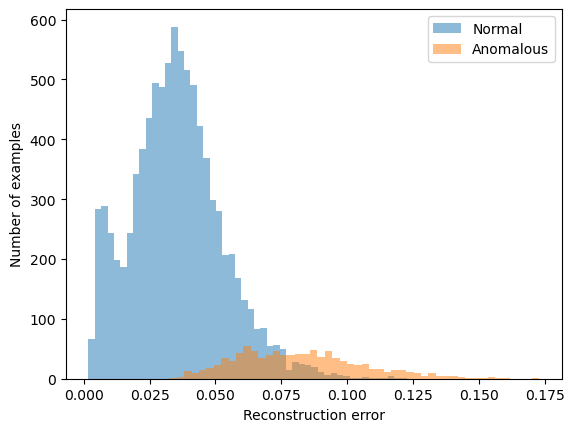

Reconstruction error threshold: 0.0704
Anomaly detection accuracy: 93.48%


In [17]:
# Plot histograms of reconstruction errors
plt.hist(errors_normal, bins=50, alpha=0.5, label="Normal")
plt.hist(errors_anomalous, bins=50, alpha=0.5, label="Anomalous")
plt.legend()
plt.xlabel("Reconstruction error")
plt.ylabel("Number of examples")
plt.show()

# Compute threshold (e.g., mean + 2*std of normal errors)
threshold = np.mean(errors_normal) + 2 * np.std(errors_normal)
print(f"Reconstruction error threshold: {threshold:.4f}")

# Classification based on threshold
true_labels = np.concatenate(
    [np.zeros(len(errors_normal)), np.ones(len(errors_anomalous))]
)
predicted_labels = np.concatenate(
    [np.array(errors_normal) > threshold, np.array(errors_anomalous) > threshold]
)

# Compute accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Anomaly detection accuracy: {accuracy*100:.2f}%")

In [ ]:


**Explanation:**

- We plot histograms of reconstruction errors for normal and anomalous data to visualize the separation.
- We set a threshold based on the distribution of normal errors.
- We classify examples as anomalies if their reconstruction error exceeds the threshold.
- We compute the accuracy of our anomaly detection model.

---



In [ ]:


## Detailed Explanation

**Data Preparation:**

- **Normal Data**: All images of digit '0'.
- **Anomalous Data**: Images of digits '1' to '9'.

**Model Training:**

- The autoencoder learns to reconstruct images of digit '0'.
- Since it's only trained on normal data, it expects inputs similar to the normal class.

**Anomaly Detection:**

- **Reconstruction Error**: Calculated as the mean squared error between input and output.
- **Threshold Setting**: Based on the reconstruction errors of normal data.
  - We use `threshold = mean + 2 * std` of normal errors.
- **Classification**:
  - **Normal**: Reconstruction error ≤ threshold.
  - **Anomalous**: Reconstruction error > threshold.

**Evaluation:**

- **Accuracy**: Percentage of correctly classified examples (both normal and anomalous).
- **Visualization**: Histograms show the separation between normal and anomalous reconstruction errors.

---

## Conclusion

This example demonstrates how an autoencoder can be used for anomaly detection. By training the model on normal data, it learns to reconstruct this data well. When it encounters data that differs from the training distribution (anomalies), the reconstruction error increases, allowing us to detect anomalies.

**Important Points:**

- The choice of threshold is crucial for the performance of anomaly detection.
- The model's capacity and training quality affect its ability to reconstruct normal data accurately.
- This approach assumes that anomalies are sufficiently different from normal data so that the autoencoder cannot reconstruct them well.

---

Let me know if you have any questions or need further clarification on any part of the code or the concepts involved!

Where are we explicit for anomaly detecting using that this neurale network is an autoencoder and not just a network that can recognize images of digits

That's an excellent question! Let me clarify how we are utilizing the autoencoder architecture specifically for anomaly detection and how it differs from a typical classification neural network that recognizes digits.

---

## **Understanding the Difference: Autoencoder vs. Classifier**

### **Autoencoder:**

- **Purpose:** Learn to **reconstruct its input** data.
- **Training Data:** Typically trained **only on normal data**.
- **Anomaly Detection Mechanism:** Based on **reconstruction error**.
  - **Normal Data:** Low reconstruction error.
  - **Anomalous Data:** High reconstruction error because the autoencoder hasn't learned features from anomalous data.

### **Classifier:**

- **Purpose:** Learn to **assign labels** to input data (e.g., digit recognition).
- **Training Data:** Requires labeled data for **all classes** you want to recognize.
- **Anomaly Detection Mechanism:** Can detect known classes but may not generalize well to unknown anomalies; typically doesn't perform well in **unsupervised anomaly detection** without retraining.

---

## **How the Autoencoder is Used for Anomaly Detection in Our Code**

In the provided code:

1. **Training Phase:**

   - **Data Used:** We train the autoencoder **only on images of the digit '0'** (our normal class).
   - **Objective:** The autoencoder learns to **encode and then decode** these images, minimizing the reconstruction error (difference between the input and reconstructed output).
   - **No Labels Used for Reconstruction:** The labels (digits) are not used during training, except for filtering normal data. The autoencoder doesn't learn to classify or recognize digits.

2. **Anomaly Detection Phase:**

   - **Data Used:** We test the autoencoder on both **normal data** (digit '0') and **anomalous data** (digits '1' to '9').
   - **Mechanism:**
     - **Reconstruction Error Computed:** For each test image, we compute the **reconstruction error** (mean squared error between the original and reconstructed images).
     - **Threshold Applied:** We use a threshold (e.g., mean plus two standard deviations of normal data errors) to decide whether a test image is normal or anomalous.
       - **If the reconstruction error is below the threshold:** The image is considered **normal**.
       - **If the reconstruction error is above the threshold:** The image is considered **anomalous**.

3. **No Classification of Digits:**

   - The autoencoder **does not learn to classify digits**.
   - It doesn't output labels or probabilities for different digits.
   - It **only tries to reconstruct** the input images it was trained on (digit '0' images).

---

## **Why It's Not Just a Digit Recognizer**

- **Absence of Classification Layers:**
  - There are **no layers dedicated to classification** (e.g., softmax or logistic regression layers).
  - The network ends with reconstruction layers, aiming to output an image, not a class label.

- **Use of Reconstruction Error:**
  - The decision to label data as normal or anomalous is based on **how well the data can be reconstructed**, not on classification accuracy.
  - An image of digit '1' will likely have a **higher reconstruction error** because the autoencoder hasn't learned the features specific to digit '1'.

- **Unsupervised Learning Approach:**
  - The autoencoder is trained in an **unsupervised manner** with respect to class labels.
  - It learns the **underlying structure of normal data** without any explicit instruction about anomalies.

---

## **Detailed Explanation with Code References**

### **Training the Autoencoder on Normal Data Only**

```python
# Filter the dataset to only include the normal class (digit '0')
normal_class = 0

# Indices of normal data in training set
train_indices = [i for i, (x, y) in enumerate(train_dataset) if y == normal_class]

# Subset the training dataset to include only normal data
train_dataset_normal = Subset(train_dataset, train_indices)

# Data loader for training on normal data only
train_loader = DataLoader(train_dataset_normal, batch_size=batch_size, shuffle=True)
```

- **Purpose:** Ensures the autoencoder **only sees normal data** during training.

### **Autoencoder Architecture**

```python
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            # ...
        )
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            # ...
            nn.Unflatten(1, (1, 28, 28))
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
```

- **Key Points:**
  - **No classification layers:** The network is designed to **reconstruct** input images.
  - **Latent Space Representation:** The encoder compresses the data into a lower-dimensional latent space.

### **Computing Reconstruction Errors for Anomaly Detection**

```python
def compute_reconstruction_errors(loader):
    errors = []
    with torch.no_grad():
        for data in loader:
            imgs, _ = data
            outputs = model(imgs)
            # Reshape images and outputs to (batch_size, -1)
            imgs = imgs.view(imgs.size(0), -1)
            outputs = outputs.view(outputs.size(0), -1)
            # Compute per-sample reconstruction errors
            batch_errors = torch.mean((outputs - imgs) ** 2, dim=1)
            errors.extend(batch_errors.cpu().numpy())
    return errors
```

- **Function Purpose:** Computes the **reconstruction error** for each sample in the dataset.
- **Error Calculation:** Mean squared error between the input image and its reconstruction.

### **Setting Threshold and Detecting Anomalies**

```python
# Compute errors on normal and anomalous test data
errors_normal = compute_reconstruction_errors(test_loader_normal)
errors_anomalous = compute_reconstruction_errors(test_loader_anomalous)

# Compute threshold based on normal data reconstruction errors
threshold = np.mean(errors_normal) + 2 * np.std(errors_normal)

# Classify samples based on whether their reconstruction error exceeds the threshold
predicted_labels_normal = np.array(errors_normal) > threshold
predicted_labels_anomalous = np.array(errors_anomalous) > threshold
```

- **Threshold Setting:** Based on statistics of the reconstruction errors of normal data.
- **Anomaly Detection:** Samples exceeding the threshold are labeled as anomalies.
- **No Classification Based on Digit Recognition:** We are not using any digit recognition logic; instead, we rely solely on the autoencoder's reconstruction capability.

---

## **Why a Classifier Would Not Serve the Same Purpose**

- **Limitation in Detecting Unknown Anomalies:**
  - A classifier trained to recognize digits '0' to '9' may not detect **anomalies that are outside the known classes**.
  - It would attempt to classify any input into one of the known classes.

- **Supervised vs. Unsupervised Learning:**
  - Classifiers require **labeled data** and **supervised learning**.
  - Our goal is to detect anomalies **without explicit labels for anomalies**, which is better suited for **unsupervised learning** methods like autoencoders.

- **Generalization to Unknown Anomalies:**
  - Autoencoders can potentially detect any data that deviates from the normal pattern, including **unknown or unforeseen anomalies**.
  - Classifiers are limited to distinguishing between predefined classes.

---

## **Conceptual Summary**

- **Autoencoder for Anomaly Detection:**
  - Learns to reconstruct normal data patterns.
  - Anomalies are detected when the data cannot be reconstructed well (high reconstruction error).

- **Classifier for Digit Recognition:**
  - Learns to assign labels to input data based on features.
  - Doesn't inherently have a mechanism for detecting data that doesn't fit into known classes.

---

## **An Illustration with Reconstruction Examples**

To further clarify, let's consider what happens when the autoencoder processes normal vs. anomalous data:

### **Processing Normal Data (Digit '0'):**

- **Input:** Image of digit '0'.
- **Reconstruction:** Since the autoencoder is trained on digit '0', it can reconstruct it accurately.
- **Reconstruction Error:** Low.

### **Processing Anomalous Data (Digit '2'):**

- **Input:** Image of digit '2'.
- **Reconstruction:** The autoencoder has never seen digit '2' during training; thus, it cannot reconstruct it accurately.
- **Reconstruction Error:** High.

**Visualization:**

- **Original and Reconstructed Images:**
  - For normal data, the reconstructed image closely matches the original.
  - For anomalous data, the reconstructed image differs significantly, often resembling features of the normal data it was trained on.

---

## **Practical Implications**

- **Detection of Novel Anomalies:**
  - The autoencoder can detect anomalies that are **not predefined**, making it useful in scenarios where anomalies are rare or unknown.

- **No Need for Anomaly Labels:**
  - Since anomalies are defined by deviation from normal patterns, we don't need labeled anomalous data.

- **Applicability:**
  - This approach is widely used in fields like **fraud detection**, **fault detection in machinery**, and **network intrusion detection**, where anomalies are rare and varied.

---

## **Summary**

- **Explicit Use of Autoencoder:**
  - The network's architecture and training procedure are designed specifically for **reconstruction**, not classification.
  - Anomaly detection leverages the autoencoder's inability to reconstruct unseen or anomalous data accurately.

- **Not a Digit Recognition Network:**
  - The model doesn't recognize or classify digits; it doesn't output labels.
  - Labels are only used to select **normal data** during training and to evaluate performance during testing.

---

## **Conclusion**

- By training an autoencoder solely on normal data and using the reconstruction error as a metric, we explicitly use the autoencoder's properties for anomaly detection.
- This method is fundamentally different from a classification network that recognizes digits, both in architecture and in the way we use the network for detecting anomalies.

---

**Feel free to ask if you have further questions or need more clarification on any aspect!**